# Social Media Sentiment Analysis by Pranjal Dhamane

Social media has revolutionized the way people access information worldwide, bringing it within a click's reach. With this accessibility comes a flood of opinions, both positive and negative, on various topics. Unfortunately, this freedom of expression also fosters instances of cyberbullying and the spread of hate speech. 

**Objective for the Project:**

Conduct sentiment analysis on a Twitter dataset to discern the prevailing attitudes towards specific topics or entities. By analyzing sentiments expressed in tweets, the project aims to uncover patterns of positive and negative sentiment, identify potential instances of cyberbullying or hate speech, and provide insights into the overall sentiment landscape on Twitter.

In [101]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
from nltk import PorterStemmer
import warnings
import re
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 200
warnings.filterwarnings("ignore", category = DeprecationWarning)
%matplotlib inline

In [34]:
# reading the file
df = pd.read_csv('social_media.csv', delimiter=',', encoding='latin-1')

# Data Exploration

In [35]:
# glancing over the dataset
display(df.head(),df.tail(),df.sample(5))

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


,id,label,tweet
49154,49155,NaN,thought factory: left-right polarisation! #tru...
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverre...
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...
49157,49158,NaN,"happy, at work conference: right mindset leads..."
49158,49159,NaN,"my song ""so glad"" free download! #shoegaze ..."


,id,label,tweet
40599,40600,NaN,it's 2016 and still so much hate in this count...
19884,19885,0.0,both covered Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂÃ...
16355,16356,0.0,the reunion #photoftheday #me #daphne
22395,22396,0.0,people's affects: people are #happy (30.8%) &a...
8465,8466,0.0,almost holiday time @user #cantwait #holiday


In [36]:
# checking the dimension of the dataset
df.shape

(49159, 3)

It has 49k rows and 3 columns

In [37]:
# checking dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      49159 non-null  int64  
 1   label   31962 non-null  float64
 2   tweet   49159 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


`id` and `labels` are __numeric column__ and `tweet` is our __categorical column__ that contains nominal data

# Data Cleaning

We need to perform the following
- create a new column for cleaned data
- remove any non textual data that cannot be interpreted by the model like  punctuations, numbers and special characters 
- removing stopwards; stopwords are words that occur frequently in a language but typically do not carry significant meaning or contribute to the context of a sentence. Examples of stopwords in English include "the," "is," "and," "of," "in," etc. they usually have length of less than 3 and they do not contribute a lot to the analysis

In [38]:
def clean_text(text, patterns_to_remove=[]):
    # Remove patterns
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
    
    # Remove special characters and keep only letters and hashtags
    text = re.sub("[^a-zA-Z#]", " ", text)
    
    # Remove short words (length less than or equal to 3)
    text = ' '.join([word for word in text.split() if len(word) > 3])
    
    return text

The regex @[\w]* matches the "@" symbol followed by any sequence of word characters (letters, digits, or underscores), commonly used to identify and remove mentions of usernames in social media text.

In [39]:
patterns_to_remove = ["@[\w]*"]

# Apply the clean_text function to a DataFrame column
df['cleaned_tweets'] = df['tweet'].apply(lambda x: clean_text(x, patterns_to_remove))

df.head()

,id,label,tweet,cleaned_tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


# Tokenization

Tokenization is the process of splitting a text into smaller units, such as words or phrases, called tokens. For example, consider the sentence: "The quick brown fox jumps over the lazy dog." Tokenizing this sentence would result in the following tokens:

"The"
"quick"
"brown"
"fox"
"jumps"
"over"
"the"
"lazy"
"dog"

Each word in the sentence becomes a separate token, allowing for further analysis or processing at the individual word level.

In [40]:
# tokenize the cleaned_tweets column by splitting each text into individual words
# apply the split() method to each text in the cleaned_tweets column
# store the tokenized tweets in the tokenized_tweets series
tokenized_tweets = df['cleaned_tweets'].apply(lambda x: x.split())

# display the first few rows of the tokenized_tweets series
tokenized_tweets.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: cleaned_tweets, dtype: object

# Stemming

Stemming is the process of reducing words to their root or base form by removing suffixes or prefixes. 

For example, the word "running" would be stemmed to "run", and "fishing" to "fish". This helps to group together different variations of the same word, simplifying text analysis tasks.

In [42]:
# create an instance of the PorterStemmer class
stemmer = PorterStemmer()

# apply stemming to each tokenized tweet
# iterate over each tweet in the tokenized_tweets series
# for each tweet, iterate over each token (word) in the tweet
# apply stemming to each token using the stem() method of the stemmer object
# return a list of stemmed tokens for each tweet
tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

# displaying the first few rows of the transformed tokenized_tweets series
tokenized_tweets.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: cleaned_tweets, dtype: object

In [43]:
# combining them back together
# iterate over each element (tweet) in the tokenized_tweets list
for i in range(len(tokenized_tweets)):
    # joining the list of tokenized words back into a single string, separated by spaces
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])

# assign the modified tokenized_tweets list to a new column named 'Clean_Tweets' in the combined_data DataFrame
df['clean_tweets'] = tokenized_tweets

# display the first few rows of the combined_data DataFrame to verify the changes
df.head()

,id,label,tweet,cleaned_tweets,clean_tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation,factsguid societi #motiv


# Data Visualization

In [48]:
# storing all non negative words
positive_words = ' '.join(text for text in df['cleaned_tweets'][df['label'] == 0])

In [51]:
# Generating images
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We will use the ImageColorGenerator to generate the color of the image
image_color = ImageColorGenerator(Mask)

# Now we will use the WordCloud function of the wordcloud library
wc = WordCloud(background_color='white',height=1500,width=4000,mask=Mask).generate(positive_words)

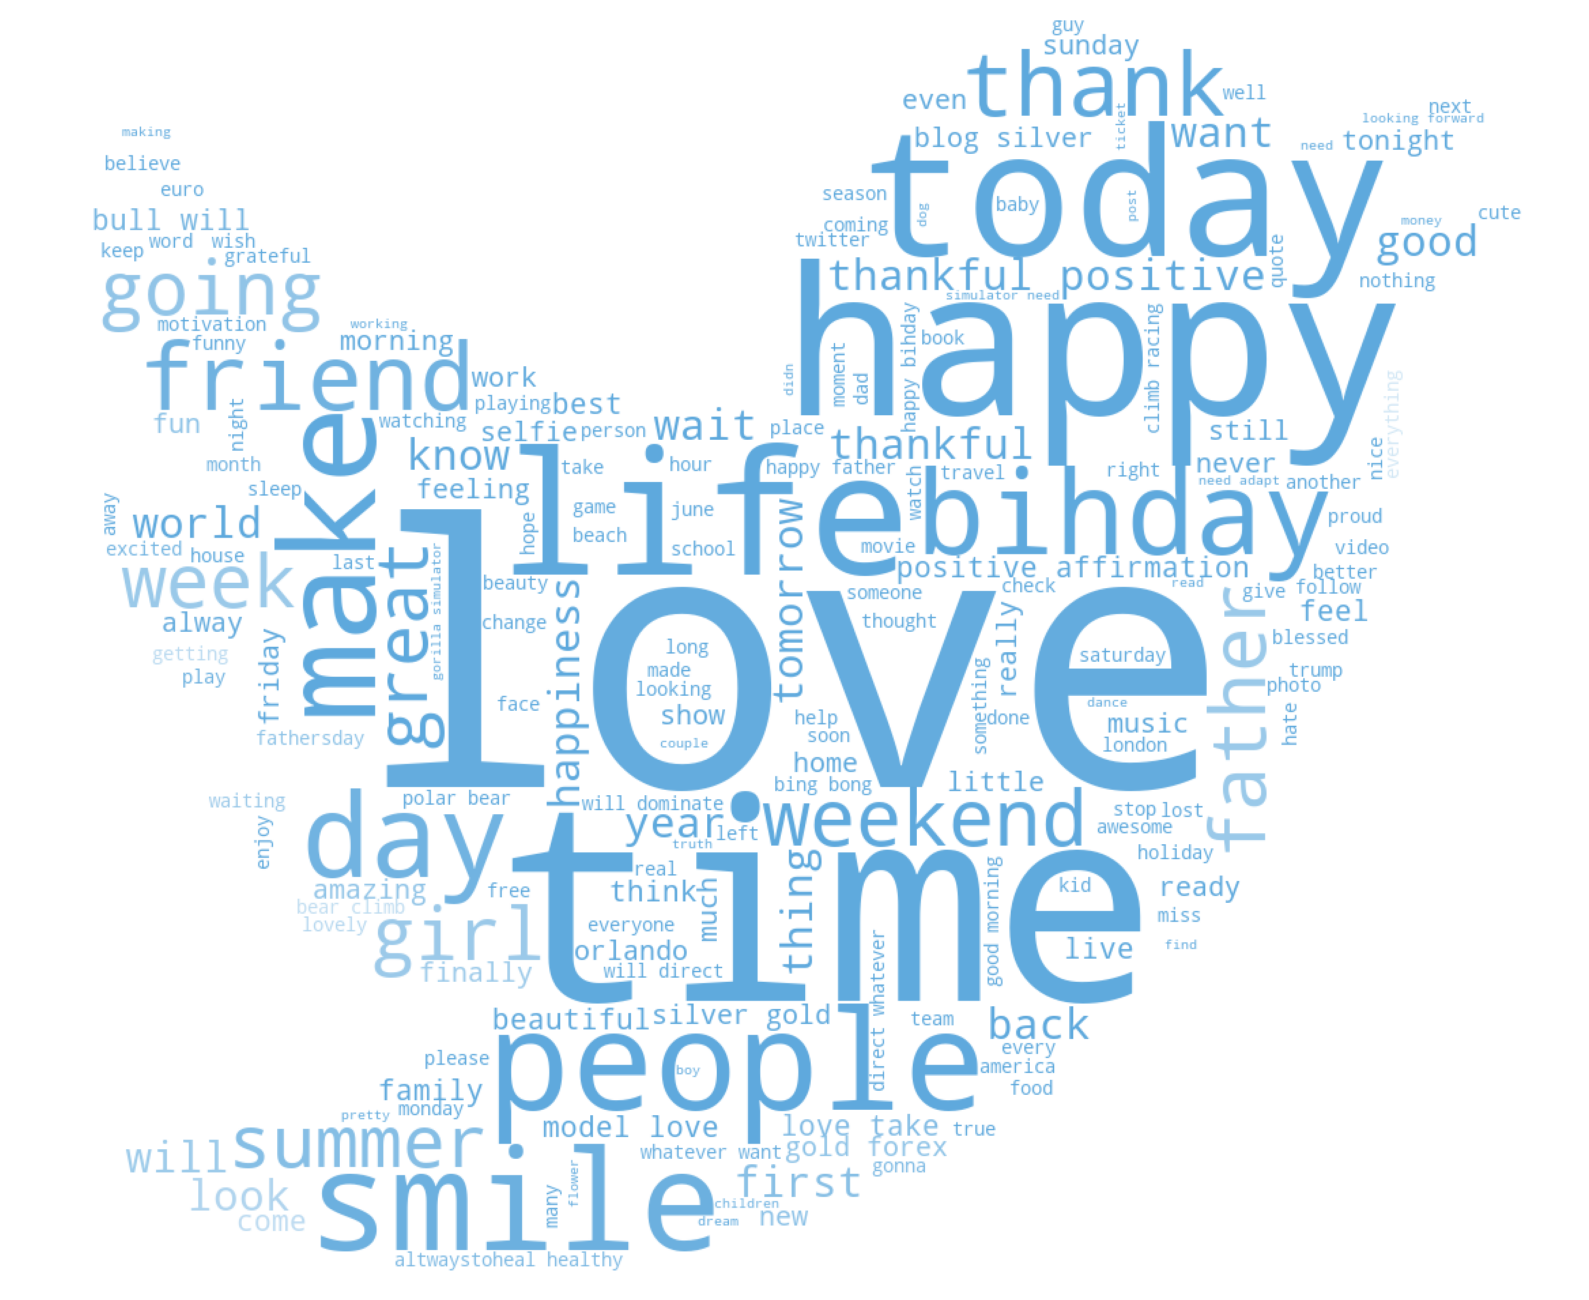

In [52]:
# Size of the image generated
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# interpolation is used to smooth the image generated

plt.imshow(wc.recolor(color_func=image_color),interpolation="hamming")

plt.axis('off')
plt.show()

In [57]:
# storing all negative words
negative_words = ' '.join(text for text in df['clean_tweets'][df['label'] == 1])

# Combining Image with Dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(negative_words)

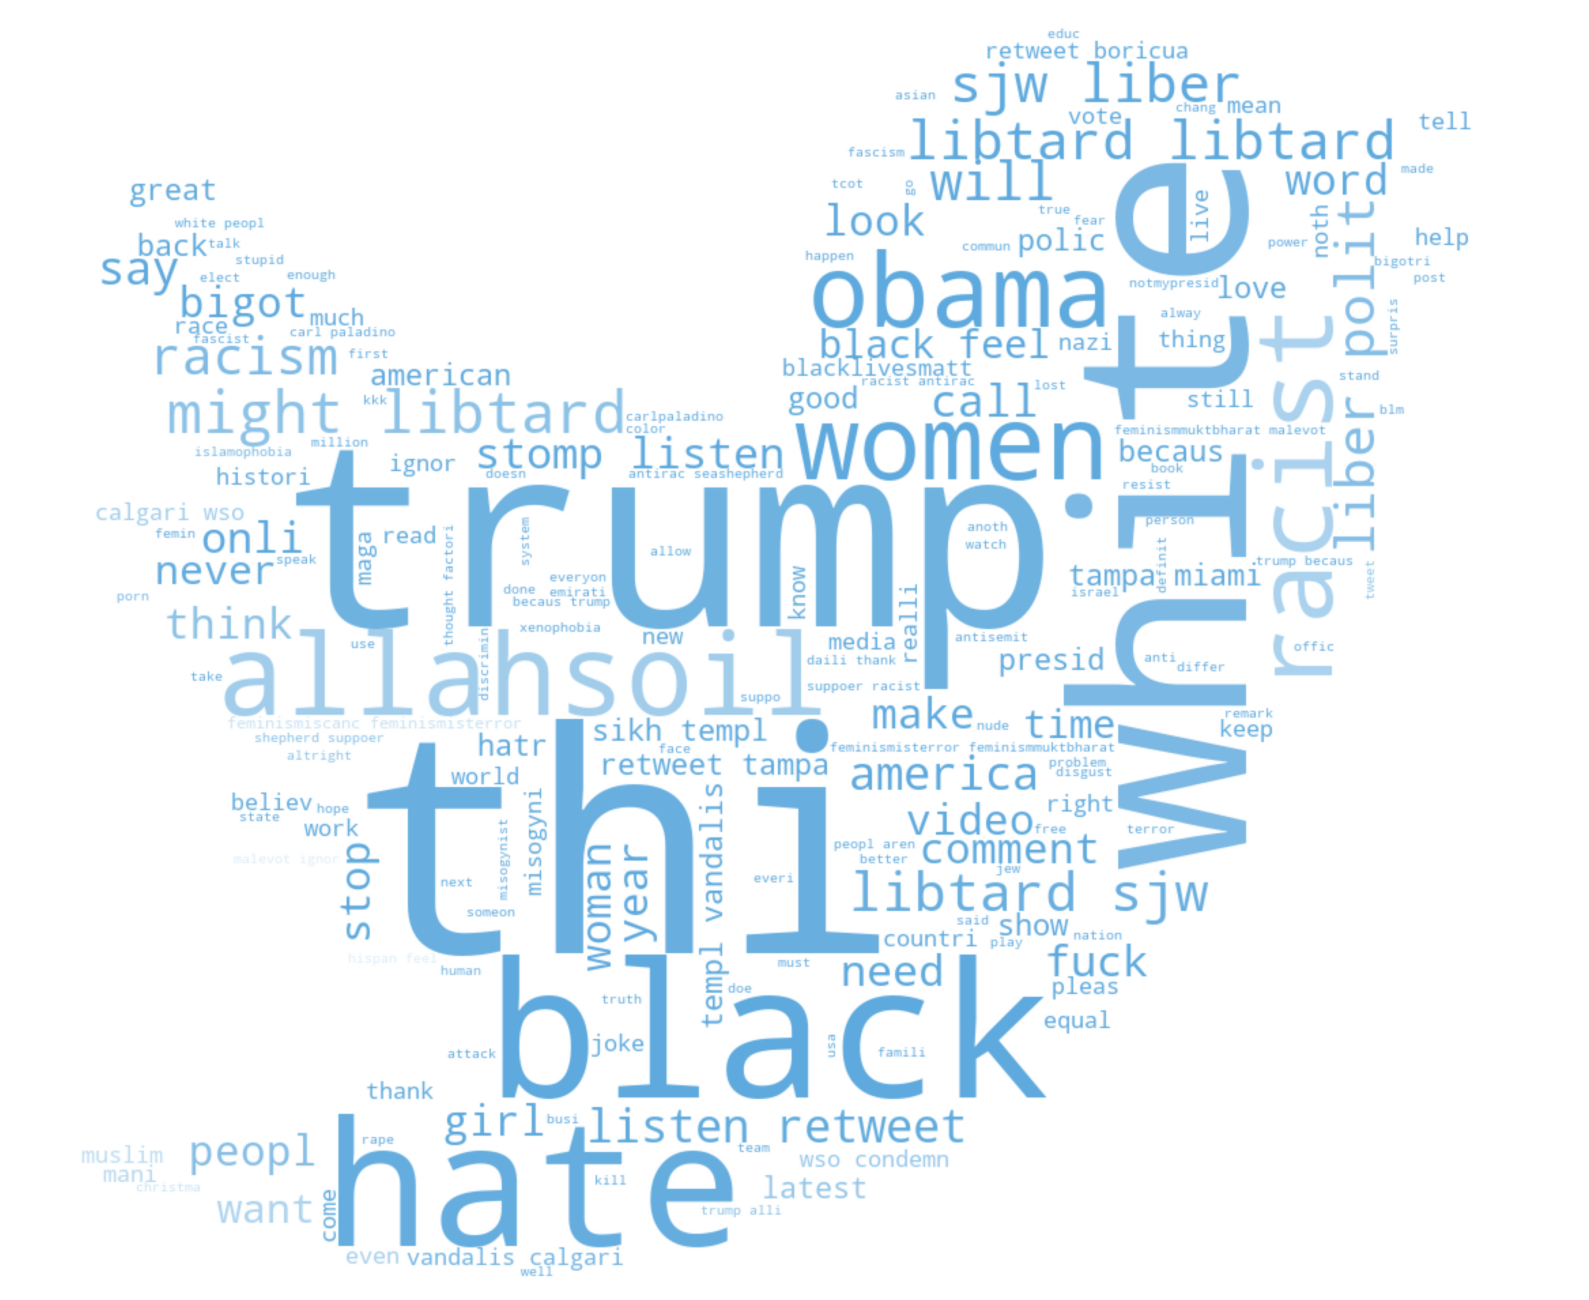

In [58]:
# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="gaussian")

plt.axis('off')
plt.show()

# Hashtag Extraction

In [66]:
def extract_hashtags(x):
    hashtags = []
    
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags

### Positive Hastag Extraction

In [60]:
positive_hashtags = extractHashtags(df['cleaned_tweets'][df['label'] == 0])

positive_hashtags

[['run'],
 ['lyft', 'disapointed', 'getthanked'],
 [],
 ['model'],
 ['motivation'],
 ['allshowandnogo'],
 [],
 ['school',
  'exams',
  'hate',
  'imagine',
  'actorslife',
  'revolutionschool',
  'girl'],
 ['allin', 'cavs', 'champions', 'cleveland', 'clevelandcavaliers'],
 [],
 ['ireland', 'blog', 'silver', 'gold', 'forex'],
 ['orlando',
  'standwithorlando',
  'pulseshooting',
  'orlandoshooting',
  'biggerproblems',
  'selfish',
  'heabreaking',
  'values',
  'love'],
 ['gettingfed'],
 ['got', 'junior', 'yugyoem', 'omg'],
 ['thankful', 'positive'],
 ['friday', 'cookies'],
 [],
 ['euro'],
 ['badday', 'coneofshame', 'cats', 'pissed', 'funny', 'laughs'],
 ['wine', 'weekend'],
 ['tgif', 'gamedev', 'indiedev', 'indiegamedev', 'squad'],
 ['upsideofflorida', 'shopalyssas', 'love'],
 ['smiles', 'media', 'pressconference', 'antalya', 'turkey', 'throwback'],
 ['ica'],
 [],
 ['rip', 'orlando'],
 [],
 ['alohafriday', 'time', 'not', 'exist', 'positivevibes', 'hawaiian'],
 [],
 ['goodnight', 'badm

In [62]:
# unnesting the list 
positive_hastags_unnested = sum(positive_hashtags,[])
positive_hastags_unnested

['run',
 'lyft',
 'disapointed',
 'getthanked',
 'model',
 'motivation',
 'allshowandnogo',
 'school',
 'exams',
 'hate',
 'imagine',
 'actorslife',
 'revolutionschool',
 'girl',
 'allin',
 'cavs',
 'champions',
 'cleveland',
 'clevelandcavaliers',
 'ireland',
 'blog',
 'silver',
 'gold',
 'forex',
 'orlando',
 'standwithorlando',
 'pulseshooting',
 'orlandoshooting',
 'biggerproblems',
 'selfish',
 'heabreaking',
 'values',
 'love',
 'gettingfed',
 'got',
 'junior',
 'yugyoem',
 'omg',
 'thankful',
 'positive',
 'friday',
 'cookies',
 'euro',
 'badday',
 'coneofshame',
 'cats',
 'pissed',
 'funny',
 'laughs',
 'wine',
 'weekend',
 'tgif',
 'gamedev',
 'indiedev',
 'indiegamedev',
 'squad',
 'upsideofflorida',
 'shopalyssas',
 'love',
 'smiles',
 'media',
 'pressconference',
 'antalya',
 'turkey',
 'throwback',
 'ica',
 'rip',
 'orlando',
 'alohafriday',
 'time',
 'not',
 'exist',
 'positivevibes',
 'hawaiian',
 'goodnight',
 'badmonday',
 'taylorswift',
 'travelingram',
 'dalat',
 'ri

## Negative Hashtag Extraction

In [67]:
negative_hashtags = extract_hashtags(df['cleaned_tweets'][df['label'] == 1])

In [69]:
# unnesting the list 
negative_hashtags_unnest = (sum(negative_hashtags,[]))
negative_hashtags_unnest

['cnn',
 'michigan',
 'tcot',
 'australia',
 'opkillingbay',
 'seashepherd',
 'helpcovedolphins',
 'thecove',
 'helpcovedolphins',
 'neverump',
 'xenophobia',
 'love',
 'peace',
 'race',
 'identity',
 'med',
 'altright',
 'whitesupremacy',
 'linguistics',
 'race',
 'power',
 'raciolinguistics',
 'brexit',
 'people',
 'trump',
 'republican',
 'michelleobama',
 'knicks',
 'golf',
 'jewishsupremacist',
 'libtard',
 'sjw',
 'liberal',
 'politics',
 'trash',
 'hate',
 'stereotyping',
 'prejudice',
 'hope',
 'hate',
 'conflict',
 'pols',
 'bluelivesmatter',
 'draintheswamp',
 'ferguson',
 'antisemitism',
 'hocoschools',
 'columbiamd',
 'hocomd',
 'nazi',
 'hatred',
 'bigotry',
 'libtard',
 'sjw',
 'liberal',
 'politics',
 'fyi',
 'tcot',
 'topoli',
 'blacklivesmatter',
 'ushistory',
 'eugenics',
 'biherism',
 'bigotry',
 'altright',
 'potus',
 'theresistance',
 'crime',
 'officer',
 'black',
 'retweet',
 'tampa',
 'miami',
 'allahsoil',
 'praised',
 'cleveland',
 'rnc',
 'white',
 'tamirrice

# Visualizing barplot

In [75]:
# word frequencies
positive_word_freq = nltk.FreqDist(positive_hastags_unnested)
display(positive_word_freq)

negative_word_freq = nltk.FreqDist(negative_hashtags_unnest)
display(negative_word_freq)

FreqDist({'love': 1596, 'positive': 880, 'smile': 581, 'healthy': 576, 'thankful': 496, 'fun': 463, 'life': 431, 'summer': 395, 'model': 365, 'cute': 365, ...})

FreqDist({'trump': 136, 'politics': 95, 'allahsoil': 92, 'libtard': 76, 'liberal': 75, 'sjw': 74, 'retweet': 63, 'miami': 46, 'black': 44, 'hate': 33, ...})

In [77]:
# creating a dataframe of the most frequently used words in hashtags
positive_df = pd.DataFrame({'Hashtags': list(positive_word_freq.keys()),'Count' : list(positive_word_freq.values())})
display(positive_df)

negative_df = pd.DataFrame({'Hashtags':list(negative_word_freq.keys()),'Count':list(negative_word_freq.values())})
display(negative_df)

,Hashtags,Count
0,run,34
1,lyft,2
2,disapointed,1
3,getthanked,2
4,model,365
...,...,...
20744,kamp,1
20745,ucsd,1
20746,berlincitygirl,1
20747,genf,1


,Hashtags,Count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5
...,...,...
1805,jumpedtheshark,1
1806,freemilo,5
1807,milo,4
1808,mailboxpride,1


# Plotting barplot for top 15 positive and negative words

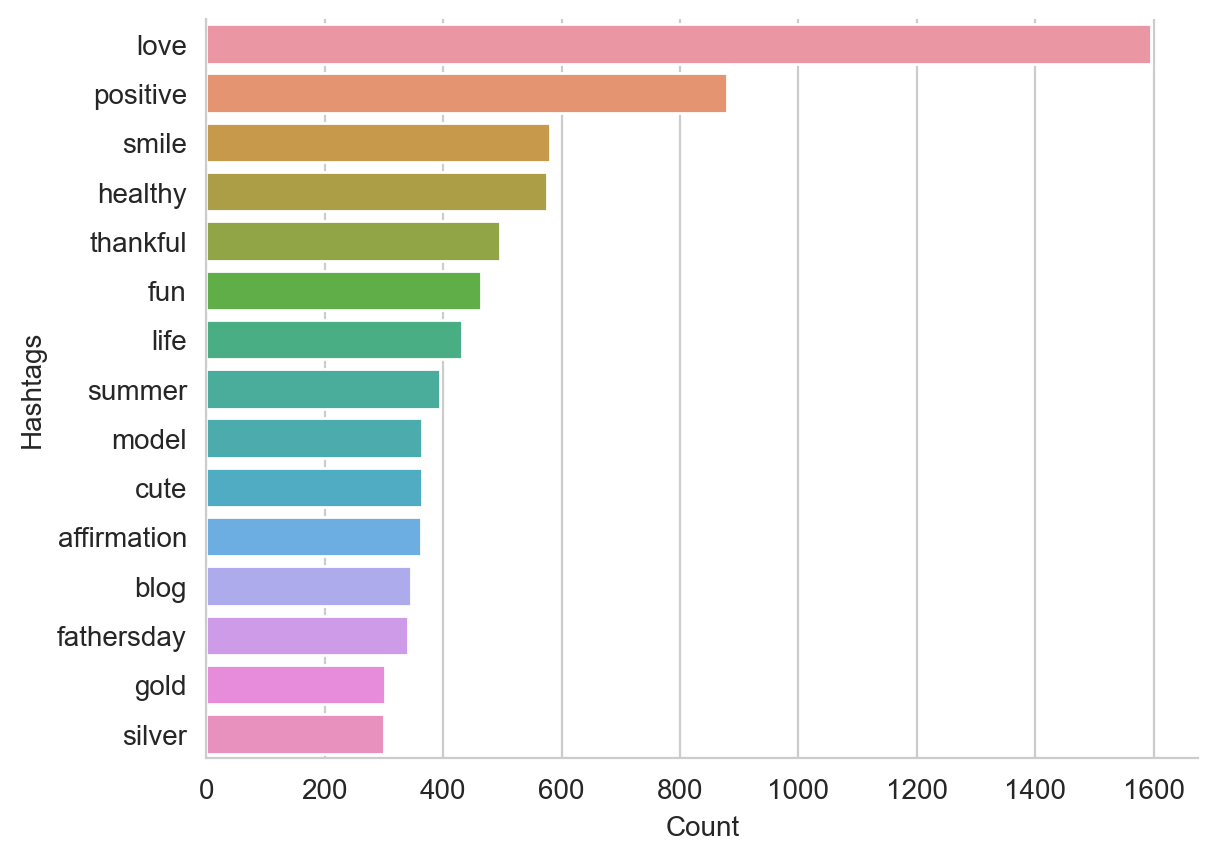

In [83]:
positive_df_plot = positive_df.nlargest(15,columns='Count')

sns.barplot(data=positive_df_plot,y='Hashtags',x='Count')
sns.despine()

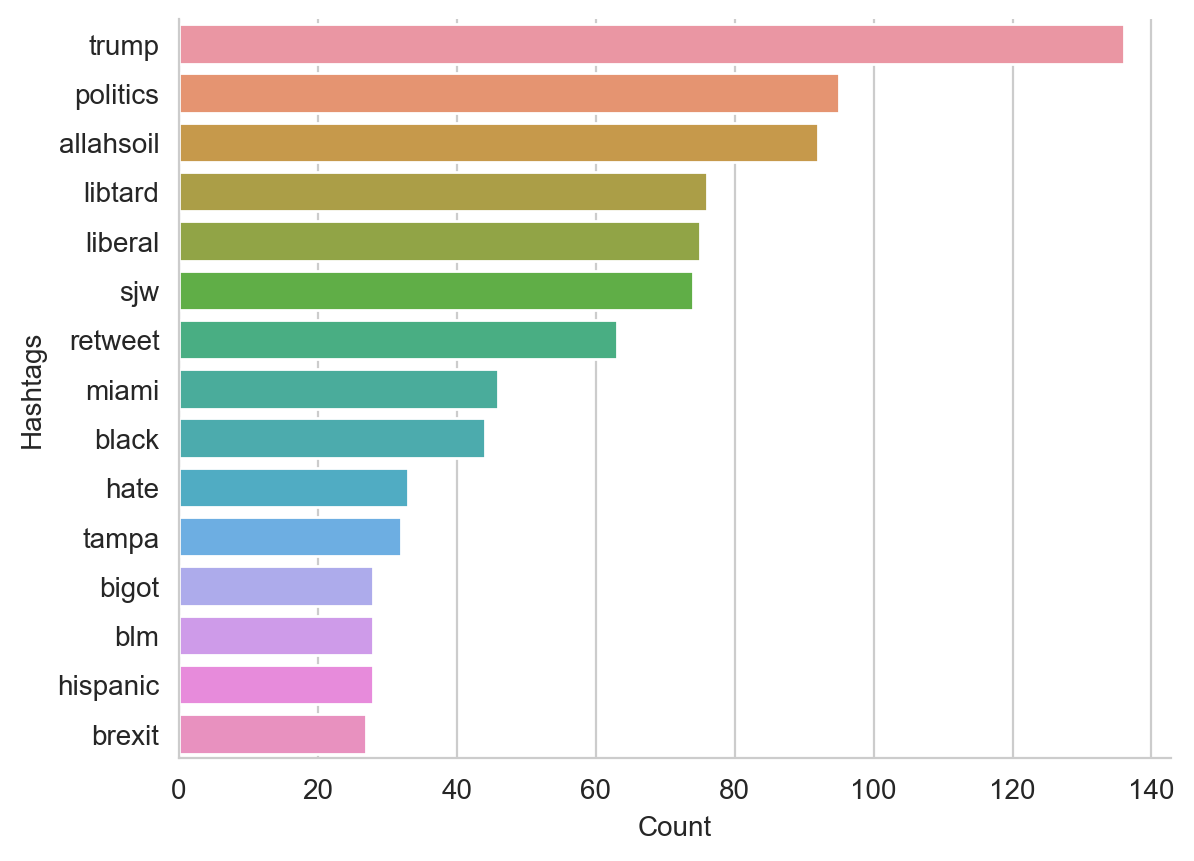

In [82]:
negative_df_plot = negative_df.nlargest(15,columns='Count')

sns.barplot(data=negative_df_plot,y='Hashtags',x='Count')
sns.despine()

# Feature Extraction

Applying Bag of Words method to embed the data

In [86]:
# Initialize a CountVectorizer object with specified parameters:
# - max_df: Ignore terms that have a document frequency higher than 90%
# - min_df: Ignore terms that have a document frequency lower than 2
# - max_features: Limit the number of features (words) to 1000, based on frequency
# - stop_words: Remove common English stop words
bag_of_words_vecotrizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words="english")

# Apply the CountVectorizer to the 'Cleaned_Tweets' column of the combined_data DataFrame
# This converts the text data into a bag-of-words representation, where each row represents a tweet
# and each column represents a word, with values indicating the frequency of each word in each tweet
bag_of_words = bag_of_words_vecotrizer.fit_transform(df['cleaned_tweets'])

# Convert the bag-of-words matrix to a dense DataFrame for easier manipulation and analysis
bag_of_words_df = pd.DataFrame(bag_of_words.todense())

# Display the DataFrame containing the bag-of-words representation of the tweets
bag_of_words_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# Initialize a TfidfVectorizer object with specified parameters:
# - max_df: Ignore terms that have a document frequency higher than 90%
# - min_df: Ignore terms that have a document frequency lower than 2
# - max_features: Limit the number of features (words) to 1000, based on TF-IDF weights
# - stop_words: Remove common English stop words
tfidf = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# Apply the TfidfVectorizer to the 'cleaned_tweets' column of the DataFrame df
# This converts the text data into a TF-IDF matrix, where each row represents a tweet
# and each column represents a word, with values indicating the TF-IDF weight of each word in each tweet
tfidf_matrix = tfidf.fit_transform(df['cleaned_tweets'])

# Convert the TF-IDF matrix to a dense DataFrame for easier manipulation and analysis
tfidf_df = pd.DataFrame(tfidf_matrix.todense())

# Display the DataFrame containing the TF-IDF representation of the tweets
tfidf_df


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
train_bag_of_words = bag_of_words[:31962]
train_bag_of_words.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

The code extracts the first 31962 rows of the bag-of-words matrix
This subset represents the training data used to train the model, enabling efficient model training and evaluation.

In [92]:
train_tfidf_matrix = tfidf_matrix[:31962]
train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

The code extracts the first 31962 rows of the TF-IDF matrix, This subset represents the training data used to train the model, allowing for efficient model training and evaluation

# Splitting data into training data and testing data

In [99]:
# bag of words split
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bag_of_words,df['label'][:31962],test_size=0.3,random_state=2)

In [100]:
# tf-idf split
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,df['label'][:31962],test_size=0.3,random_state=17)

# Modelling: Logistic Regression

In [102]:
# Fitting bag of words
log_Reg = LogisticRegression(random_state=0,
         solver='lbfgs').fit(x_train_bow,y_train_bow)

In [103]:
predict_bow = log_Reg.predict_proba(x_valid_bow)
predict_bow

array([[9.44062599e-01, 5.59374006e-02],
       [9.99328996e-01, 6.71004149e-04],
       [9.12290521e-01, 8.77094795e-02],
       ...,
       [8.67205327e-01, 1.32794673e-01],
       [9.60148578e-01, 3.98514224e-02],
       [9.69889126e-01, 3.01108740e-02]])

### Calculating F1 Score

In [105]:
# If prediction is more than or equal to 0.3 then 1 else 0
prediction_int = predict_bow[:,1] >=0.3

# Converting to integer type
prediction_int = prediction_int.astype(np.int64)
prediction_int

# Calculating f1 score
log_bow = f1_score(y_valid_bow, prediction_int)
log_bow

0.5331098072087175

In [106]:
# Fitting TF-IDF
log_Reg.fit(x_train_tfidf,y_train_tfidf)

LogisticRegression(random_state=0)

In [107]:
predict_tfidf = log_Reg.predict_proba(x_valid_tfidf)
predict_tfidf

array([[0.98255214, 0.01744786],
       [0.965703  , 0.034297  ],
       [0.94003419, 0.05996581],
       ...,
       [0.93162594, 0.06837406],
       [0.96526145, 0.03473855],
       [0.98783098, 0.01216902]])

In [108]:
prediction_int = predict_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int64)
prediction_int

log_tfidf = f1_score(y_valid_tfidf,prediction_int)
log_tfidf

0.5546666666666666

# Predicting on test data


In [116]:
test = df[31962:]

In [117]:
test_tfidf = tfidf_matrix[31962:]
test_pred = log_Reg.predict_proba(test_tfidf)

test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int64)

test['label'] = test_pred_int

submission = df[['id','label']]
submission.to_csv('result.csv', index=False)

C:\Users\Asif Sayyed\AppData\Local\Temp\ipykernel_2860\2484025640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['label'] = test_pred_int


# Results after prediction:
For a negative label : 1
For a positive label : 0

In [119]:
result = pd.read_csv('result.csv')
result

,id,label
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
...,...,...
49154,49155,NaN
49155,49156,NaN
49156,49157,NaN
49157,49158,NaN
